In [1]:
%matplotlib widget

import roboticstoolbox as rt

import numpy as np
from spatialmath import SE3,SO3, base

In [175]:
# utility funcitons for finding random but feasible initial and final robot poses with specified distance between them
# both initial and final pose have the same random orientation
def rand_num(delta):
    return np.random.rand()*2*delta - delta
def find_random_poses_with_distance(distance, iterations = 100):
    X_init = None
    while X_init is None or np.linalg.norm(panda.fkine(panda.ikine_LM(X_init).q).t-X_init.t) > 1e-5:
        X_init = SE3(np.random.rand(1,3)*0.5-0.25+np.array([0.5,0,0.4]))*SE3(SO3(X_r.R))*SE3(SO3.Rx(rand_num(np.pi/6)))*SE3(SO3.Ry(rand_num(np.pi/6)))
    
    X_final = None
    while X_final is None or np.linalg.norm(panda.fkine(panda.ikine_LM(X_final).q).t-X_final.t) > 1e-5:
        print("not attainable final")
        v= np.random.rand(3)*2-1
        v = v/np.linalg.norm(v)*distance
        X_final = SE3(X_init.t + v)*SE3(SO3(X_init.R))
    
    return X_init, X_final

# Panda model with robtoics toolbox

In [176]:
panda = rt.models.DH.Panda()
# initial pose
q0= np.array([0 ,0,0,   -1.6, 0,    1.57, 0])
panda.q = q0

# swet target location
X_r = panda.fkine(q0)

## And the limits

In [183]:
# limits
# joint space
dq_max = np.array([2.1750, 2.1750,2.1750,2.1750,2.6100, 2.6100,2.6100])
dq_min = -dq_max
ddq_max = np.array([15,7.5,10,12.5,15,20,20])
ddq_min = -ddq_max
dddq_max = np.array([7500, 3750, 5000,6250,7500,10000,10000])
dddq_min = -dddq_max

# cartesian space
dddx_max = np.array([6500.0,6500.0,6500.0])
dddx_min = -dddx_max
ddx_max = np.array([13.0,13,13])
ddx_min = -ddx_max
dx_max = np.array([1.7,1.7,1.7])
dx_min = -dx_max

# Define the CS straight line trajectory

In [188]:
# desired trajectory lenght
traje_len = 0.3

from spatialmath import SE3,SO3
X_init, X_final = find_random_poses_with_distance(traje_len)

print('initial point:\t', X_init.t)
print('final point:\t',X_final.t)

d = np.linalg.norm(X_final.t-X_init.t)
print('traj length:\t',d)

not attainable final
not attainable final
not attainable final
initial point:	 [0.71557297 0.24588373 0.23100033]
final point:	 [ 0.5635753   0.31075204 -0.01937701]
traj length:	 0.3


## Find the JS waypoints

In [189]:
# distance between waypoinys
d_waypoint = 0.06 # m
# number of waypoints in joint space
n_waypoints  = int(d/d_waypoint)
print('waypoints num:\t',n_waypoints)

# calculate the JS waypoints
X_i = np.linspace(X_init.t, X_final.t, n_waypoints)
q_line = [ panda.ikine_LM(X_init,q0 = q0, joint_limits=True).q ]
for x in X_i[1:]:
    T = SE3(x)*SE3(SO3(X_init.R))
    sol = panda.ikine_LM(T,q0 = q0, joint_limits=True)         # solve IK
    q_line.append(sol.q)

waypoints num:	 5


# Calcualte TOPP-RA tajectory with scaled limits

In [190]:
import toppra as ta
import toppra.constraint as constraint
import toppra.algorithm as algo
import numpy as np
import matplotlib.pyplot as plt
import time

In [191]:
#capacity scaling
scale  = 1.0
print('capacity scale:\t',scale)

ss = np.linspace(0,1,len(q_line))
path = ta.SplineInterpolator(ss, q_line)
pc_vel = constraint.JointVelocityConstraint(scale*dq_max)
pc_acc = constraint.JointAccelerationConstraint(scale*ddq_max)
instance = algo.TOPPRA([pc_vel, pc_acc], path,parametrizer="ParametrizeConstAccel")
jnt_traj = instance.compute_trajectory()
print('trajectory execution time:',jnt_traj.duration)

capacity scale:	 1.0
trajectory execution time: 0.5005198000593819


# Extact and visualise toppra's data

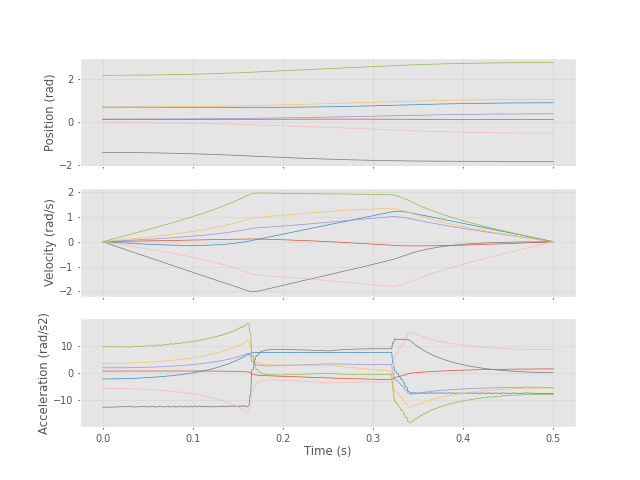

In [192]:
ts_sample = np.linspace(0, jnt_traj.duration, int(jnt_traj.duration*1000))
qs_sample = jnt_traj(ts_sample)
qds_sample = jnt_traj(ts_sample, 1)
qdds_sample = jnt_traj(ts_sample, 2)
fig, axs = plt.subplots(3, 1, sharex=True)
for i in range(path.dof):
    # plot the i-th joint trajectory
    axs[0].plot(ts_sample, qs_sample[:, i], c="C{:d}".format(i))
    axs[1].plot(ts_sample, qds_sample[:, i], c="C{:d}".format(i))
    axs[2].plot(ts_sample, qdds_sample[:, i], c="C{:d}".format(i))
axs[2].set_xlabel("Time (s)")
axs[0].set_ylabel("Position (rad)")
axs[1].set_ylabel("Velocity (rad/s)")
axs[2].set_ylabel("Acceleration (rad/s2)")
plt.show()

# Calculate CS variables

In [193]:
x3d , dx, ddx ,dddx = [], [], [], []

for i in range(len(ts_sample)):
    x_t = panda.fkine(qs_sample[i,:]).t
    x3d.append(x_t)
    J = panda.jacob0(qs_sample[i,:])
    Jdot = panda.jacob0_dot(qs_sample[i,:],qds_sample[i,:])
    dx.append(J@qds_sample[i,:])
    ddx.append(J@qdds_sample[i,:] + Jdot@qds_sample[i,:])
    
x3d = np.array(x3d)
dx = np.array(dx)
ddx = np.array(ddx)

In [194]:
c = np.array(X_init.t - X_final.t) #path direciton

# velocity in the path direction
s = x3d@c
ds = dx[:,:3]@c
dds = ddx[:,:3]@c

In [195]:
fig, axs = plt.subplots(1, 3, sharex=True)
axs[0].set_title('position')
axs[0].plot(ts_sample,s)
axs[1].set_title('velocity')
axs[1].plot(ts_sample,ds)
axs[2].set_title('acceleration')
axs[2].plot(ts_sample,dds)

# Visualise the path and the trajecory

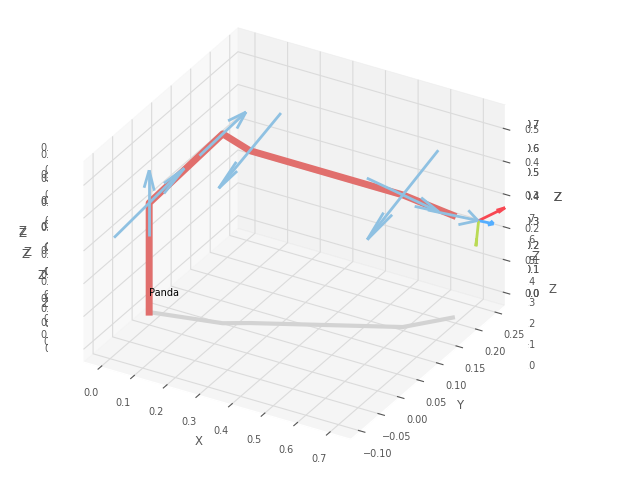

In [196]:
fig = panda.plot(panda.ikine_LM(X_init,q0).q)
ax = fig.ax
x = np.vstack((X_init.t, X_final.t))
ax.plot(x[:,0],x[:,1],x[:,2],'r', label='ideal')
ax.plot(x3d[:,0],x3d[:,1],x3d[:,2],'b',label='toppra')
plt.legend()